

This is an example of medical data to use regex to extract relevant infromation from the data. 

Each line of the `dates.txt` file corresponds to a medical note. Each note has a date that needs to be extracted, but each date is encoded in one of many formats.

The goal is to correctly identify all of the different date variants encoded in this dataset and to properly normalize and sort the dates. 

Here is a list of some of the variants in this dataset:
* 04/20/2009; 04/20/09; 4/20/09; 4/3/09
* Mar-20-2009; Mar 20, 2009; March 20, 2009;  Mar. 20, 2009; Mar 20 2009;
* 20 Mar 2009; 20 March 2009; 20 Mar. 2009; 20 March, 2009
* Mar 20th, 2009; Mar 21st, 2009; Mar 22nd, 2009
* Feb 2009; Sep 2009; Oct 2010
* 6/2008; 12/2009
* 2009; 2010

Assumtions:
* All dates in xx/xx/xx format are mm/dd/yy
* All dates where year is encoded in only two digits are years from the 1900's (e.g. 1/5/89 is January 5th, 1989)
* If the day is missing (e.g. 9/2009), assume it is the first day of the month (e.g. September 1, 2009).
* If the month is missing (e.g. 2010), assume it is the first of January of that year (e.g. January 1, 2010).
* This is a raw, real-life derived dataset.

With the rules, the correct date in each note needs to be found.


In [39]:
import pandas as pd
pd.options.display.max_rows = 20
doc = []
with open('dates.txt') as file:
    for line in file:
        doc.append(line)

df = pd.Series(doc)
df.head(5)

0         03/25/93 Total time of visit (in minutes):\n
1                       6/18/85 Primary Care Doctor:\n
2    sshe plans to move as of 7/8/71 In-Home Servic...
3                7 on 9/27/75 Audit C Score Current:\n
4    2/6/96 sleep studyPain Treatment Pain Level (N...
dtype: object

In [40]:
def date_sorter():
    
    df[298] = 'January 1993'
    df[313] = 'December 1978'
    
    df_dates = df.str.extract(r'(\d{0,2}/\d{0,2}/(?:\d\d)?(?:\d\d)\b)|'
            r'(\d{1,2}-{1}\d{1,2}-{1}\d{2})|'
            r'((?:\d{1,2})?/\d{4})|' 
            r'(?:[\s|\w|\.|\(|\b|~])(\d{4}\b)|'     
            r'(^\d{4})|'    
            r'((?:\d{1,2}\s)?(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\b.? ?(?:\d{1,2}[a-z]*)?,? \d{4})'
                             )
    df_dates[6] = pd.to_datetime(df_dates[df_dates.columns[0]])
    df_dates[7] = pd.to_datetime(df_dates[df_dates.columns[1]])
    df_dates[8] = pd.to_datetime(df_dates[df_dates.columns[2]])
    df_dates[9] = pd.to_datetime(df_dates[df_dates.columns[3]])
    df_dates[10] = pd.to_datetime(df_dates[df_dates.columns[4]])
    df_dates[11] = pd.to_datetime(df_dates[df_dates.columns[5]])

    clean_dates = df_dates[df_dates.columns[6:12]]
    clean_dates2 = clean_dates.max(axis=1)
    df_dates[12] = clean_dates2
    df_dates[13] = df
    df_dates = df_dates[[12, 13]]
    df_dates.columns = ['Converted', 'Original']
    df_dates.sort_values(by='Converted', inplace=True)

    return df_dates
df_dates = date_sorter()




In [41]:
print(df_dates.head())

     Converted                                           Original
474 1972-01-01  sPatient reported losing three friends that pa...
153 1972-01-13                 13 Jan 1972 Primary Care Doctor:\n
13  1972-01-26  1/26/72 Communication with referring physician...
129 1972-05-06                  06 May 1972 SOS-10 Total Score:\n
98  1972-05-13  5/13/72 Other Adult Mental Health Outcomes Sca...


Checking the converted data, it's obvious that there is a problem. Some dates are in the future.

<AxesSubplot:xlabel='Converted', ylabel='Count'>

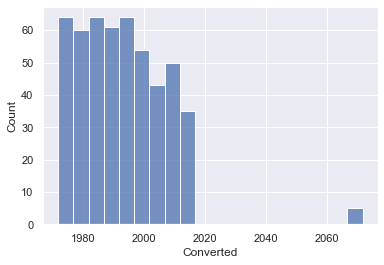

In [42]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.histplot(df_dates['Converted'])


The error was introduced with the conversion string to date, the library assumes that the year "17" is 2017. So, I corrected this with a DateOffset. 

In [43]:
from pandas.tseries.offsets import DateOffset
test = df_dates['Converted'] > '2020-01-01'
offset = DateOffset(years=100)
print(df_dates[test])
df_dates['Converted'] = df_dates['Converted'].where(df_dates['Converted'] < '2020-01-01', df_dates['Converted'] - offset)


    Converted                                           Original
9  2071-04-10           (4/10/71)Score-1Audit C Score Current:\n
84 2071-05-18        5/18/71 Total time of visit (in minutes):\n
2  2071-07-08  sshe plans to move as of 7/8/71 In-Home Servic...
53 2071-07-11                      7/11/71 SOS-10 Total Score:\n
28 2071-09-12                             9/12/71 [report_end]\n


In [44]:
df_dates

,Converted,Original
474,1972-01-01,sPatient reported losing three friends that pa...
153,1972-01-13,13 Jan 1972 Primary Care Doctor:\n
13,1972-01-26,1/26/72 Communication with referring physician...
129,1972-05-06,06 May 1972 SOS-10 Total Score:\n
98,1972-05-13,5/13/72 Other Adult Mental Health Outcomes Sca...
...,...,...
9,1971-04-10,(4/10/71)Score-1Audit C Score Current:\n
84,1971-05-18,5/18/71 Total time of visit (in minutes):\n
2,1971-07-08,sshe plans to move as of 7/8/71 In-Home Servic...
53,1971-07-11,7/11/71 SOS-10 Total Score:\n


In [45]:
test2 = df_dates[(df_dates['Converted'] > '2000-01-01') & (df_dates['Converted'] < '2020-01-01') ]
test2

,Converted,Original
305,2000-02-01,. The patient was hospitalized in Feb 2000 at ...
260,2000-02-01,".Iredell Memorial Hospital, February 2000, aft..."
420,2000-03-01,.Patient reports overall stable mental health ...
329,2000-03-01,"CLLC and DCF - ended in March, 2000. Psychiatr..."
392,2000-05-01,TSH 0.67 5/2000 Prior EEG:\n
...,...,...
231,2016-05-01,50 yo DWF with a history of alcohol use disord...
141,2016-05-30,30 May 2016 SOS-10 Total Score:\n
186,2016-10-13,13 Oct 2016 Primary Care Doctor:\n
161,2016-10-19,19 Oct 2016 Communication with referring physi...


<AxesSubplot:xlabel='Converted', ylabel='Count'>

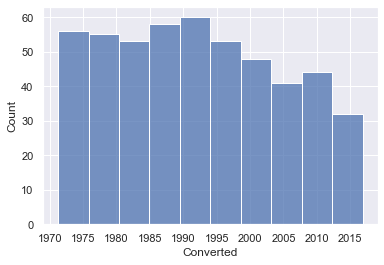

In [46]:
sns.histplot(df_dates['Converted'])